<a href="https://colab.research.google.com/github/bessoh2/IA_DEM_Roughness/blob/Hannah_branch/FirstLookGM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explore Grand Mesa data
## Calculating the Rolling Window Standard Deviation of the Elevation, and Exploratory Statistics of this Output

In [ ]:
# Import necessary packages
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# Use geopandas for vector data and rasterio for raster data
import geopandas as gpd
import rasterio as rio
import rioxarray as riox
import xarray as xr
# Plotting extent is used to plot raster & vector data together
from rasterio.plot import plotting_extent
from scipy import stats

# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="white")

%matplotlib inline

### Set the Working Directory and Point to the Data

In [ ]:
#set working directory?
os.chdir(os.path.join('/Users',
                      'Hannah',
                    'Documents', 
                      'Documents_Grad', 
                      'Research', 
                      'ICESat_2',
                     'data'))

In [ ]:
fn = os.path.join("ASO",
                        "snow_off",
                        "GrandMesa",
                       "ASO_3M_PCDTM_USCOGM_20160926_20160926.tif")

In [ ]:
!pwd

/Users/Hannah/Documents/Documents_Grad/Research/ICESat_2/data


### Open the Dataset using Xarray, Set -9999 values to nan, and Plot

In [ ]:
im = xr.open_rasterio(fn)

In [ ]:
im = im.squeeze()

In [ ]:
im = im.where(im != (-9999.))
#gm_std_low = gm_std_2d.where(gm_std_2d < 4)

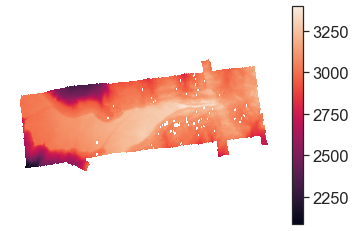

In [ ]:
plt.imshow(im)
plt.colorbar()
plt.axis('off');

### Introduce the Function I wrote, changed slightly to avoid creating a tuple for simplicity

In [ ]:
# This function computes the rolling stadard deviation, taking as input an xarray DataArray

def rolling_stdev(im, size):                # im: a DataArray loaded in using xarray. size: define the size (dimension of one side) of your moving window
  """
  Short Summary
  --------------------
  This function calculates the rolling standard deviation within a window of
  specified dimensions.

  Extended Summary
  ------------------
  This function utilizes xarray's rolling window operation to first create a 
  Rolling object, and then to apply that Rolling object to the DataArray
  to calculate standard deviation within each (size, size) window. The output is
  a new DataArray with each pixel populated with the standard deviation of all 
  pixels within the window for which the pixel was at the center. This function
  also outputs a plot of the output file for quick and easy data visualization.

  Parameters
  ------------
  im:   DataArray
        Generally a .tif file that has been loaded in using xarray.open_rasterio()
  size 
        The dimension of the square rolling window to use. If one dimension is supplied, 
        it will be propagated to the proper number of dimensions. For example, a size
        set to 3 will generate a rolling window square of dimensions (3,3).

  Returns
  ------------
  tuple
        consisting of the new DataArray of standard deviation values
        and the figure and axes of the plot of this new DataArray
  
  Example
  -------------
  Implement by saving the output as a variable. 
  >>>output = rolling_stdev(im=im_subset, size=3)
  >>>output[0]
  xarray.DataArray

    band: 1y: 511x: 511

    nan nan nan nan nan ... 0.06020909 0.1668852 0.025760788 0.05106023
    Coordinates:
        band
        (band)
        int64
        1
        y
        (y)
        float64
        4.2e+06 4.2e+06 ... 4.198e+06
        x
        (x)
        float64
        2.272e+05 2.273e+05 ... 2.288e+05
    Attributes: (0)

  """
  
  r = im.rolling(y=size)                    # this creates the xarray Rolling object 
  im_stdev = r.reduce(np.std)               # use the Rolling object to calculate the standard deviation within each window. Could substitute other functions like mean or median. 
  
  return im_stdev

### Implement the Function

In [ ]:
gm_std = rolling_stdev(im, 3)

In [ ]:
gm_std

<xarray.DataArray (y: 6500, x: 12450)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    band     int64 1
  * y        (y) float64 4.336e+06 4.336e+06 4.336e+06 ... 4.317e+06 4.317e+06
  * x        (x) float64 2.183e+05 2.183e+05 2.183e+05 ... 2.557e+05 2.557e+05
Attributes:
    transform:      (3.0, 0.0, 218313.0, 0.0, -3.0, 4336122.0)
    crs:            +init=epsg:32613
    res:            (3.0, 3.0)
    is_tiled:       0
    nodatavals:     (-9999.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area

### Plot the Standard Deviation output, and Exclude Outliers

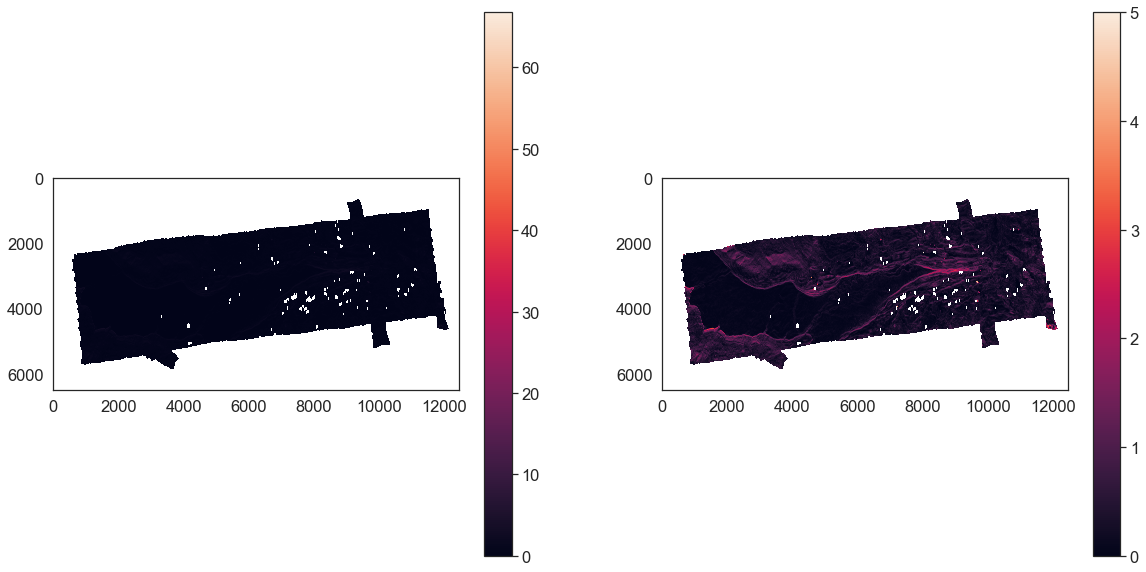

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(20,10))

c1 = ax[0].imshow(gm_std)
c2 = ax[1].imshow(gm_std, vmin=0, vmax=5)
plt.colorbar(c1, ax=ax[0])
plt.colorbar(c2, ax=ax[1]);

In [ ]:
gm_std.shape

(6500, 12450)

### Output Statistics About the Standard Deviation Output, potentially for use as thresholding values outside of Grand Mesa

In [ ]:
print(np.nanmedian(gm_std))
print(np.nanmean(gm_std))
print(np.nanmax(gm_std))
print(np.nanmin(gm_std))
#print(stats.mode(gm_std.values))

0.18067864
0.34063563
66.755646
0.0


### Subset to Standard Deviations Below 5, to Remove Outliers

In [ ]:
gm_std_low = gm_std.where(gm_std < 5)

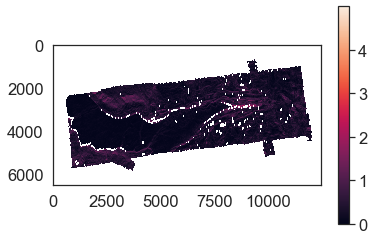

In [ ]:
plt.imshow(gm_std_low)
plt.colorbar();

In [ ]:
print(np.nanmean(gm_std_low.values))


0.33181605


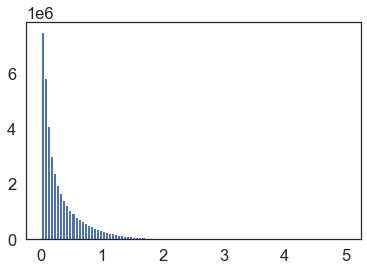

In [ ]:
plt.hist(np.ravel(gm_std_low), bins=100);